# Aufbereitung der Daten

Damit die Spektogramme überhaupt von Modellen genutzt werden können, müssen sie aufbereitet, (teilweise) bearbeitet und in einem gut verwendbarem Format abgespeichert werden.
In unserem Fall besteht das aus den folgenden Schritten:
1. Die Skala/Rahmen der Bilder entfernen
2. Die Bilder runterskalieren
3. (Optional) Filter oder andere Bildbearbeitungen anwenden
4. Daten nach Klasse aussortieren
5. Fledermausarten in Numerische Klassen umwandeln

#### Imports

In [7]:
import cv2
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from pathlib import Path
import json
from tqdm.auto import tqdm
from sklearn.utils import shuffle
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import EditedNearestNeighbours as ENN
from imblearn.combine import SMOTEENN, SMOTETomek

#### Funktion zum entfernen eines übergebenen Randes.
Wird letzendlich dafür genutzt die Skala und leeren Pixel um das Spektrogramm zu entfernen.

In [8]:
def remove_frame(img, frame):
    return img[frame[0]:frame[1], frame[2]:frame[3]]

#### Bilder einlesen
Hier wrid eine Lister aller Bilder im übergeordneten Ordner `../Bat_Orientation_Calls` erstellt.

In [9]:
folder_path = Path("../Bat_Orientation_Calls")

image_paths = [os.path.join(folder_path, file_name) for file_name in os.listdir(folder_path) if file_name.endswith(".png")]

print(f"Loaded {len(image_paths)} image paths.")


Loaded 582 image paths.


#### Bildbearbeitung
Hier werden die eingelesenen Bilder zugeschnitten, runterskaliert und optional mit Filtern o.ä. bearbeitet und anschließend in `./compressed_pictures/` gespeichert.

**Hinweis:** Zur Darstellung des Fortschritts wird tqdm genutzt.

In [10]:
for image_path in tqdm(image_paths):
    # Bild für OpenCV2 einlesen
    img = cv2.imread(image_path, -1)

    # Den Rand inkl. Skala entfernen
    # Has to be hardcoded, cause not every image has the exact pixel perfect border/scale, so an automatic detection
    #   trips up and the images would end with different sizes.
    frame = (36, 251, 55, 388)
    img = remove_frame(img, frame)

    # Größe des neuen Bildes berechnen und skalieren
    base_width = 128 # finale Breite des Bildes
    height, width, channels = img.shape
    aspect_ratio = width / height  # Width / Height
    new_width = base_width
    new_height = int(new_width / aspect_ratio)
    img = cv2.resize(img, (new_width, new_height)) 

    # Alpha Channel entfernen, da dieser keine Informationen beinhaltet
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    # Bild abspeichern
    image_name = Path(image_path).name
    cv2.imwrite(f"./compressed_pictures/{image_name}",img)
    

  0%|          | 0/582 [00:00<?, ?it/s]

#### Klassen aus CSV einlesen und anpassen
Hier werden die Klassen aus den CSV's eingelesen und anschließend unerwünschte Klassen entfernt.
Kriterien für die Unerwünschtheit sind folgende:
- Klasse ist 'Fledermaus nicht bestimmbar' oder 'Schwarzbild', da diese keine sinnvollen Informationen sind
- Klasse (bzw. Bild-ID) ist ein Duplikat
- Klasse hat weniger als 60 Samples, da diese schlichweg ungeeignet für das Trainieren eines Modells sind

Anschließend liegt ein DataFrame mit den ID-Klassen Paaren vor.

In [11]:
# Reads in classes from all csv's, and edits it
def classes_csv_to_df(file_paths: list, delimiter=";") -> pd.DataFrame:
    df_all = pd.DataFrame()
    for file_path in file_paths:
        df_current = pd.read_csv(file_path, delimiter=delimiter)
        df_all = pd.concat([df_all, df_current])

    df_all = df_all.reset_index(drop=True)
    df_all = df_all.drop_duplicates()
    df_all.drop("Filename", axis=1, inplace=True)
    df_all = remove_unwanted_datapoints(df_all)
    df_all.replace("&Mausohr ", "Mausohr", inplace=True)
    df_all = remove_less_sample_classes(df_all, 60)
    
    #df_all.drop("Species", axis=1, inplace=True)
    return df_all

# Removes all duplicate entries and entries of type 'Fledermaus nicht bestimmbar' or 'Schwarzbild'
def remove_unwanted_datapoints(df: pd.DataFrame) -> pd.DataFrame:
    ids = set()
    duplicated_ids = set()
    for row in df.iterrows():
        id = row[1]["ID"]
        if id in ids:
            duplicated_ids.add(id)
        ids.add(id)

    # print how many were droppes
    print(f"Dropped {len(duplicated_ids)} entries cause they were duplicates.")
    print(f"Dropped {len(df[df['Species'] == 'Fledermaus nicht bestimmbar']) } entries cause they were of class 'Fledermaus nicht bestimmbar'.")
    print(f"Dropped {len(df[df['Species'] == 'Schwarzbild'])} entries cause they were of class 'Schwarzbild'.")
    print(f"Dropped {len(duplicated_ids)+len(df[df['Species'] == 'Fledermaus nicht bestimmbar'])+len(df[df['Species'] == 'Schwarzbild'])} in total.")
    
    return df[~((df['ID'].isin(duplicated_ids)) |
            (df['Species'].isin(['Fledermaus nicht bestimmbar', 'Schwarzbild'])))]\
            .reset_index(drop=True)

# Remove all classes with less than 60 entries
def remove_less_sample_classes(df: pd.DataFrame, min_samples: int) -> pd.DataFrame:
    class_distribution = df['Species'].value_counts()
    valid_classes = class_distribution[class_distribution >= min_samples].index
    return df[df['Species'].isin(valid_classes)]

## execute functions

df = classes_csv_to_df(["../Auswertung_20220524.csv","../LMU_20180326_class.csv", "../LMU_20180505_classified.csv"])

print(f"DataFrame as {len(df)} different entries (Images).")


FileNotFoundError: [Errno 2] No such file or directory: '../Auswertung_20220524.csv'

#### Klassen konvertieren
Hier werden die Labels der Klassen von den Fledermausnamen in numerische Label konvertiert. Funktionen für categorische und One-Hot Encodede Labels gibt es auch, werden von uns aber nicht genutzt.

In [ ]:
def categorical_classes(df: pd.DataFrame, column_name: str):
    # df passed as call by reference
    df_copy = df.copy()
    df_copy[column_name] = df_copy[column_name].astype('category')
    return df_copy

def numerical_classes(df: pd.DataFrame, column_name: str) -> tuple[pd.DataFrame, dict[int|str]]:
    df_copy = df.copy()
    df_copy[column_name] = df_copy[column_name].astype('category')
    class_mapping = dict(enumerate(df_copy[column_name].cat.categories))
    df_copy[column_name] = df_copy[column_name].cat.codes
    return df_copy, class_mapping

def encode_classes(df: pd.DataFrame, column_name: str):
    encoded_classes = pd.get_dummies(df[column_name])
    df = df.join(encoded_classes)
    return df

df_numerical, class_mapping = numerical_classes(df, "Species")
print(class_mapping)

{0: 'Bartfledermaus', 1: 'Bechsteinfledermaus', 2: 'Fransenfledermaus', 3: 'Langohrfledermaus', 4: 'Mausohr', 5: 'Wasserfledermaus'}


#### Klassen Mapping speichern
Damit die nun numerischen Klassen noch zuordbar sind, wird das Mapping von Wert-Klasse in der Datei `./data/class_mapping.csv` gespeichert. 

In [ ]:
def class_mapping_to_csv(class_mapping_dict: dict) -> None: 
    with open('./data/class_mapping.csv', 'w') as class_mapping_csv:  
        writer = csv.writer(class_mapping_csv)
        for key, value in class_mapping_dict.items():
            writer.writerow([key, value])

class_mapping_to_csv(class_mapping)

#### Klassenverteilung plotten
Hier wird die Verteilugn der Klassen geplottet und unter `./data/class_distribution` gespeichert. Wie zu sehen ist, sind sie stark ungleichmäßig verteilt.

Species
0    2104
2     866
3     291
1     270
4     123
5      69
Name: count, dtype: int64


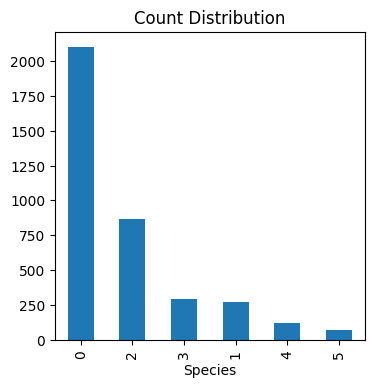

In [ ]:
def plot_class_distribution(df: pd.DataFrame):
    fig = plt.figure(figsize=(4,4))
    df['Species'].value_counts().plot.bar()
    print(df['Species'].value_counts())
    plt.title('Count Distribution')
    plt.savefig("./data/class_distribution")
    plt.show(fig)
    
plot_class_distribution(df_numerical)

#### Bilder aus ordner lesen, Klasse zuordnen und in DataFrame wandeln
In diesen Funktionen werden die bearbeiten Bilder geladen, ihnen die richtige Klasse zugeordnet und anschließend in einem DataFrame gespeichert.
**Hinweis:** Hier wird erneut tqdm verwendet.

In [ ]:
# given an ID return the according class
def get_classes_from_id(id: int, df: pd.DataFrame) -> pd.Series:
    for row in df.iterrows():
        if id == row[1]["ID"]:
            return row[1].drop("ID")

In [ ]:
def load_images_from_folder(folder_path: str, df_categorical=pd.DataFrame(), df_numerical=pd.DataFrame(), df_encoded=pd.DataFrame()) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Sicherstellen, dass mindestens ein Dataframe gegeben ist
    if not df_categorical.empty and not df_numerical.empty and not df_encoded.empty:
        raise ValueError("You have to define at least one Dataframe.")
        
    images_categorical = list()
    images_numerical = list()
    images_encoded = list()
    column_names = ["data", "Species"]
    column_names_encoded = ["data"] + list(df_encoded.columns)[1:]
    
    for i, filename in enumerate(tqdm(os.listdir(folder_path))):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):  
            # read in image
            img = cv2.imread(img_path, -1)
            # some images are broken
            if img is not None:
                # for the first image, save the size of the image to a seperate file, which makes it easier for other
                #   notebooks to get the image size & channels
                if i == 0:
                    print("The final image shape/size[hwc] is:",img.shape)
                    # store image shape in file
                    with open("./data/meta.json","w+") as file:
                        file.write(json.dumps({"h":img.shape[0],"w":img.shape[1],"c":img.shape[2]}))
                
                # Find the Class for the Image based on ID and type of given Class representation
                class_categorical = None
                class_numerical = None
                class_encoded = None
                if not df_categorical.empty:
                    class_categorical = get_classes_from_id(int(filename[:-4]), df_categorical)
                if not df_numerical.empty:
                    class_numerical = get_classes_from_id(int(filename[:-4]), df_numerical)
                if not df_encoded.empty:
                    class_encoded = get_classes_from_id(int(filename[:-4]), df_encoded)
                    
                # need to check, if the class of the image is not null [aka. image would be one of the unwanted
                #   datapoints (e.g. class Schwarzbild)]
                if (class_categorical is not None) or (class_numerical is not None) or (class_encoded is not None):
                    if not df_categorical.empty:
                        images_categorical.append([img.flatten(), *class_categorical.values])
                    if not df_numerical.empty:
                        images_numerical.append([img.flatten(), *class_numerical.values])
                    if not df_encoded.empty:
                        images_encoded.append([img.flatten(), *class_encoded.values])

    return_dfs = dict()

    if not df_categorical.empty:
        return_dfs["df_categorical"] = pd.DataFrame(np.array(images_categorical, dtype=object), columns=column_names)
    if not df_numerical.empty:
        return_dfs["df_numerical"] = pd.DataFrame(np.array(images_numerical, dtype=object), columns=column_names)
    if not df_encoded.empty:
        return_dfs["df_encoded"] = pd.DataFrame(np.array(images_encoded, dtype=object), columns=column_names_encoded).drop("Species", axis=1)

    return return_dfs

# use function
dfs = load_images_from_folder("./compressed_pictures/", df_numerical=df_numerical)

  0%|          | 0/4118 [00:00<?, ?it/s]

The final image shape/size[hwc] is: (82, 128, 3)


#### Normalisierung der Daten

Daten werden auf in ein Intervall von [0, 1] gebracht, dadurch wird die Konvergenzgeschwindigkeit verbessert

In [ ]:
for df_name, df in dfs.items():
    df['data'] = df['data'] / 255.

#### DataFrame als Pickles Datei speichern

In [ ]:
for df_name, df in dfs.items():
    if df_name == "df_categorical":
        dfs["df_categorical"].to_pickle("./data/images_df_categorical.pkl")
    if df_name == "df_numerical":
        dfs["df_numerical"].to_pickle("./data/images_df_numerical.pkl")
    if df_name == "df_encoded":
        dfs["df_encoded"].to_pickle("./data/images_df_encoded.pkl")

#### Daten einlesen

In [ ]:
data = dfs["df_numerical"]
X, y = data['data'], data['Species']
X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)

## Resampling

Aufgrund der sehr ungleich verteilten Klassen haben wir mit Oversampling (Adasyn) und einer Kombination von Under- und Oversampling (Smoteen) experimentiert. Alleiniges undersampling haben wir als nicht sinnvoll erachtet, da selbst die größten Klassen recht wenig Datenpunkte enthalten.

In [ ]:
# Entfernt Klassen >= 60 Samples
#data = data[data['Species'].isin(counts[counts>=60].index)]
# Entfernt Klassen >= 200 Samples
#data = data[data['Species'].isin(counts[counts>=200].index)]
# Entfernt Klassen >= 500 Samples
#data = data[data['Species'].isin(counts[counts>=500].index)]

In [ ]:
%%script false --no-raise-error
def resample(resampler) -> tuple[np.array, np.array]:
    X, y = data['data'], data['Species']
    X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)

    _, dist = np.unique(y, return_counts=True)
    print(f"{resampler} before res:",dist)

    X_resampled, y_resampled = resampler.fit_resample(X, y)

    _, dist = np.unique(y_resampled, return_counts=True)
    print(f"{resampler} after res:", dist)

    # shuffle ist nötig, da die synthetischen Daten nach Labels geordnet sind (random_state für bessere nachvollziehbarkeit)
    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=1)

    return X_resampled, y_resampled

In [ ]:
%%script false --no-raise-error
with open("./data/meta.json","r") as file:  # get metadata for images from file generated from import nb
    image_meta = json.load(file)
image_shape = (image_meta['h'],image_meta['w'],image_meta['c'])

**Hinweis:** Die resample_after_split-Funktion wurde benutzt um die Mengen nach dem KFold-Split einzeln zu resamplen, also z. B. nur train. Es ist der vollständigkeitshalber an dieser Stelle.

In [ ]:
%%script false --no-raise-error
def resample_after_split(X,y, resampler) -> tuple[np.array, np.array]:
    n, h, w, _ = X.shape
    X = X.reshape((n, h * w * 3))
    _, dist = np.unique(y, return_counts=True)
    print(f"{resampler} before res:",dist)

    X_resampled, y_resampled = resampler.fit_resample(X, y)

    _, dist = np.unique(y_resampled, return_counts=True)
    print(f"{resampler} after res:", dist)

    X_resampled = X_resampled.reshape((-1,) + image_shape)

    # shuffle ist nötig, da die synthetischen Daten nach Labels geordnet sind (random_state für bessere nachvollziehbarkeit)
    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=1)

    return X_resampled, y_resampled

# resample_after_split = SMOTEENN(sampling_strategy='all',enn=ENN(kind_sel='mode',n_neighbors=7))

In [ ]:
%%script false --no-raise-error
# oversampling
adasyn = ADASYN()
X_adasyn, y_adasyn = resample(adasyn)

**Hinweis:** SMOTETomek haben wir nicht weiter beachtet, da die Klassenverteilung sehr stark Adasyn ähnelte

In [ ]:
%%script false --no-raise-error
# under- und oversampling
somteenn = SMOTEENN()
X_somteenn, y_somteenn = resample(somteenn)
smotetomek = SMOTETomek()
X_smotetomek, y_smotetomek = resample(smotetomek)

**Hinweis:** Die Tests wurden auf unserem Hauptmodel CNN durchgeführt (s. CNN-Notebook)

|Durchführung|Avg. Test Acc|
|:-|-:|
| Kein Resample, top 6 classes (> 60), cnn  | 79% |
| Kein Resample, top 4 classes (>200), cnn  | 83% |
| Kein Resample, top 2 classes (>500), cnn  | 87% |
|---------------|
| Train & Validation Resample (Smotteen(all,enn=Mode,n=3)), top 6 classes (> 60), cnn   | 63% |
| Train & Validation Resample (Smotteen(all,enn=Mode,n=3)), top 4 classes (>200), cnn   | 80% |
| Train & Validation Resample (Smotteen(all,enn=Mode,n=3)), top 2 classes (>500), cnn   | 87% |
|---------------|
| Train & Validation Resample (Smotteen(all,enn=Mode,n=7)), top 6 classes (> 60), cnn   | 68% |
| Train & Validation Resample (Smotteen(all,enn=Mode,n=7)), top 4 classes (>200), cnn   | 79% |
| Train & Validation Resample (Smotteen(all,enn=Mode,n=7)), top 2 classes (>500), cnn   | 86% |
|---------------|
| Train Resample (Smotteen(all,enn=Mode,n=3)), top 6 classes (> 60), cnn   | 73% |
| Train Resample (Smotteen(all,enn=Mode,n=3)), top 4 classes (>200), cnn   | 81% |
| Train Resample (Smotteen(all,enn=Mode,n=3)), top 2 classes (>500), cnn   | 88% |

**Erbenis:** Man sieht, dass das Resampling leider in der Form keinen Vorteil bringt daher haben wir die Idee verworfen.

**Hinweis:** Wir halten die ungleiche Klassenverteilung bzw. den Mangel an Samples einiger Klassen für den Hebel mit dem meisten Verbesserungspotential. (Wenn wir die Testdaten mit resampeln erhalten wir einen Score von bis zu 92% s. unten)
Mit mehr Zeit/Domänenwissen wären folgende Dinge denkbar:
* Echte Daten vor allem der unterrepräsentierten Daten sammeln
* Synthetische Daten erzeugen, welche sehr nah den den Orginaldaten sind

#### Chunks um RAM zu sparen

Da wir extrem große RAM Probleme hatten haben wir mit Aufteilung der Daten in Chunks experimentiert, aber die Idee dann wieder verworfen, da nach der Verkleinerung der Bilder es auch ohne geklappt hat

In [ ]:
%%script false --no-raise-error
def split_df_equal_class_distribution(df, batch_size):
    
    df['temp_id'] = range(len(df))
    
    num_batches = int(np.ceil(len(df) / batch_size))
    
    grouped = df.groupby('Species', group_keys=False)
    
    chunks = []
    
    for i in range(num_batches):
        chunk = pd.DataFrame(columns=df.columns)
        for _, group in grouped:
            num_samples = int(batch_size * len(group) / len(df))
            sample_indices = np.random.choice(group['temp_id'], size=num_samples, replace=False)
            chunk = pd.concat([chunk, df[df['temp_id'].isin(sample_indices)]])
        chunk = chunk.drop('temp_id', axis=1)
        chunks.append(chunk)
    
    return chunks

batch_size = 1000

chunks_with_same_dist = split_df_equal_class_distribution(data, batch_size)
del data
classes = chunks_with_same_dist[0]["Species"].unique()
number_of_classes = classes.size
most_x_in_one_class = chunks_with_same_dist[0]["Species"].value_counts().iloc[0]

def resample(resampler) -> tuple[np.array, np.array]:
    # 0.3 als Puffer, weil sich der Output der verschiedenen Resampler ja unterscheidet
    array_size = int(most_x_in_one_class * number_of_classes * (len(chunks_with_same_dist) + 0.3))
    # 216432 war die Länge des Vektors der nicht verkleinerten Bilder
    X = np.empty((array_size, 216432), dtype=np.uint8)
    y = np.empty((array_size), dtype=np.uint8)

    current_index = 0
    for chunk in chunks_with_same_dist:
        X_batch, y_batch = chunk['data'], chunk['Species']
        X_batch, y_batch = np.stack(X_batch).astype(np.uint8), y_batch.astype(np.uint8)
        X_resampled, y_resampled = resampler.fit_resample(X_batch, y_batch)
        num_samples = X_resampled.shape[0]
        X[current_index:current_index + num_samples] = X_resampled.astype(np.uint8)
        y[current_index:current_index + num_samples] = y_resampled.astype(np.uint8)
        current_index += num_samples

    X.resize((current_index, X.shape[1]))
    y.resize(current_index)
    print(f"{resampler}: ", pd.Series(y, dtype=pd.UInt8Dtype()).value_counts())

    return X, y

num_samples = (len(X) * 0.8)
chunk_size = 1000
for i in range(0, num_samples, chunk_size):
    X[i:i+chunk_size], y[i:i+chunk_size] # Hier ist der Code abgeschnitten, da nur die Idee erläutert werden soll 

#### Bilder ausgeben

Für uns waren die Unterscheidung zwischen den Bildern der meisten Klassen nicht möglich, weshalb Domänenwissen ein sehr starken Vorteil (und in unserem Projekt auch teilweise Problem) darstellt.

In [ ]:
%%script false --no-raise-error
print(image_shape)

In [ ]:
%%script false --no-raise-error
n = 20  # Anzahl der gezeigten Bilder
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    if image_shape[2] == 1:
        plt.imshow((X[i]*255.).astype('uint8'), cmap='inferno', vmin=0, vmax=255) # for grayscale images
        plt.set_suptitle(f"{y[i]}")
    elif image_shape[2] == 4 or image_shape[2] == 3:
        plt.imshow(cv2.cvtColor((X[i]).astype('uint8'),cv2.COLOR_BGR2RGB)) # for rgb images
        ax.title.set_text(f"{y[i]}")
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.savefig("./pics.png")

# Anmerkungen zu getesteten Bildbearbeitungen
FÜr den ersten Teil der Bildaufbereitung werden hier keine Filter ö.ä. Bildbearbeitungen verwendet.
Allerdings haben wir im Laufe der Bearbeitung verschiedene Filter u.ä. ausprobiert, welche inkl. ihres Test Accuracy Wertes gelistet sind.

**Hinweis:** Die Test Accuracy Werte entsprechen denen unseres Modells, auf Basis der mit Adasyn vollständig geresampleten (auch Testdaten) Bilder. Dies hat den Grund, dass die Tests durchgeführt wurden bevor wir den Fehler entdeckt haben und die Zeit für neue Tests nicht mehr ausgereicht hat. Somit sind sie ca 10-30% höher, als auf den ungresampleten Bildern. Mehr dazu im `cnn.ipynb`.


|Bearbeitung (In Anwendungsreihenfolge)|Test Accuracy|
|:-|-:|
|Turn Pictrues into single channel grayscale|78%|
|Turn Pictrues into single channel grayscale + fastNLMeansDenoising|78%|
|fastNLMeansDenoising after downscaling|80%|
|Bilateral Filter|82%|
|Color Histogram Equalization + Contrast(*1.7) + Brightness(-150) + Bilateral Filter|82%
|fastNLMeansDenoising before downscaling|83%|
|Outlinedetection Conv2D Filter + Bilateral Filter + fastNLMeansDenoising + Contrast(*1.7) + Brightness(-150) + Sobel Conv2D Filter| 88%|
|Contrast(*1.5) + Brightness(-150)|88%|
|Contrast(*1.7) + Brightness(-100)|89%|
|Contrast(*1.7) + Brightness(-150)|89%|
|Sobel Conv2D Filter + Bilateral Filter + fastNLMeansDenoising + Bilateral Filter + Contrast(*1.7) + Brightness(-150)| 89%|
|Bilateral Filter + Contrast(*1.7) + Brightness(-100)|90%|
|Bilateral Filter + Contrast(*1.7) + Brightness(-150)|90%|
|Outlinedetection Conv2D Filter + Bilateral Filter + fastNLMeansDenoising + Bilateral Filter + Contrast(*1.7) + Brightness(-150)| 91%|
|Outlinedetection Conv2D Filter + Bilateral Filter + fastNLMeansDenoising + Bilateral Filter + Contrast(*1.7) + Brightness(-150) + Saturation=255| 91%|

Eine Veranschaulichung dieser und weitere Filter/Bildbearbeitungen ist im folgenden zu sehen:

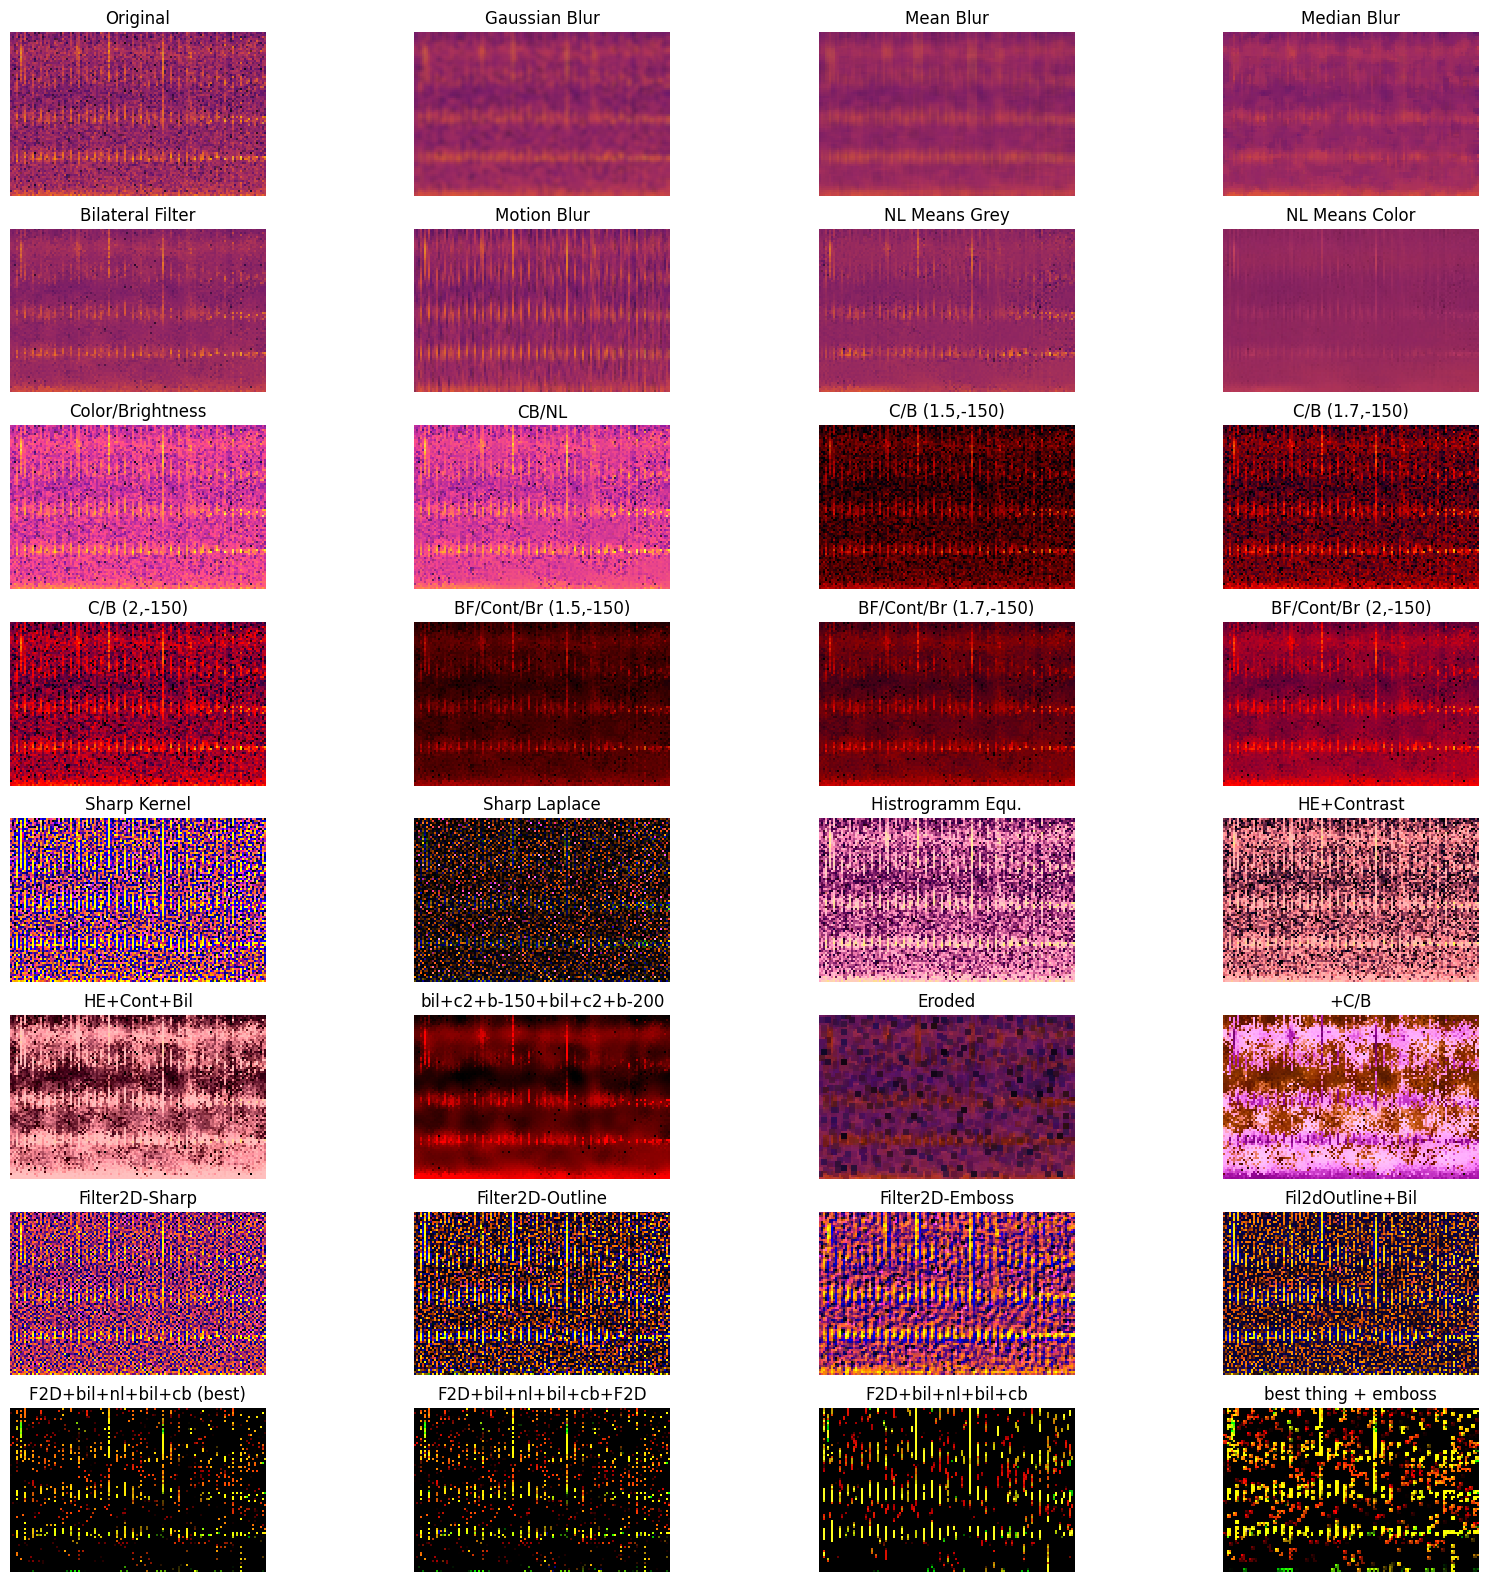

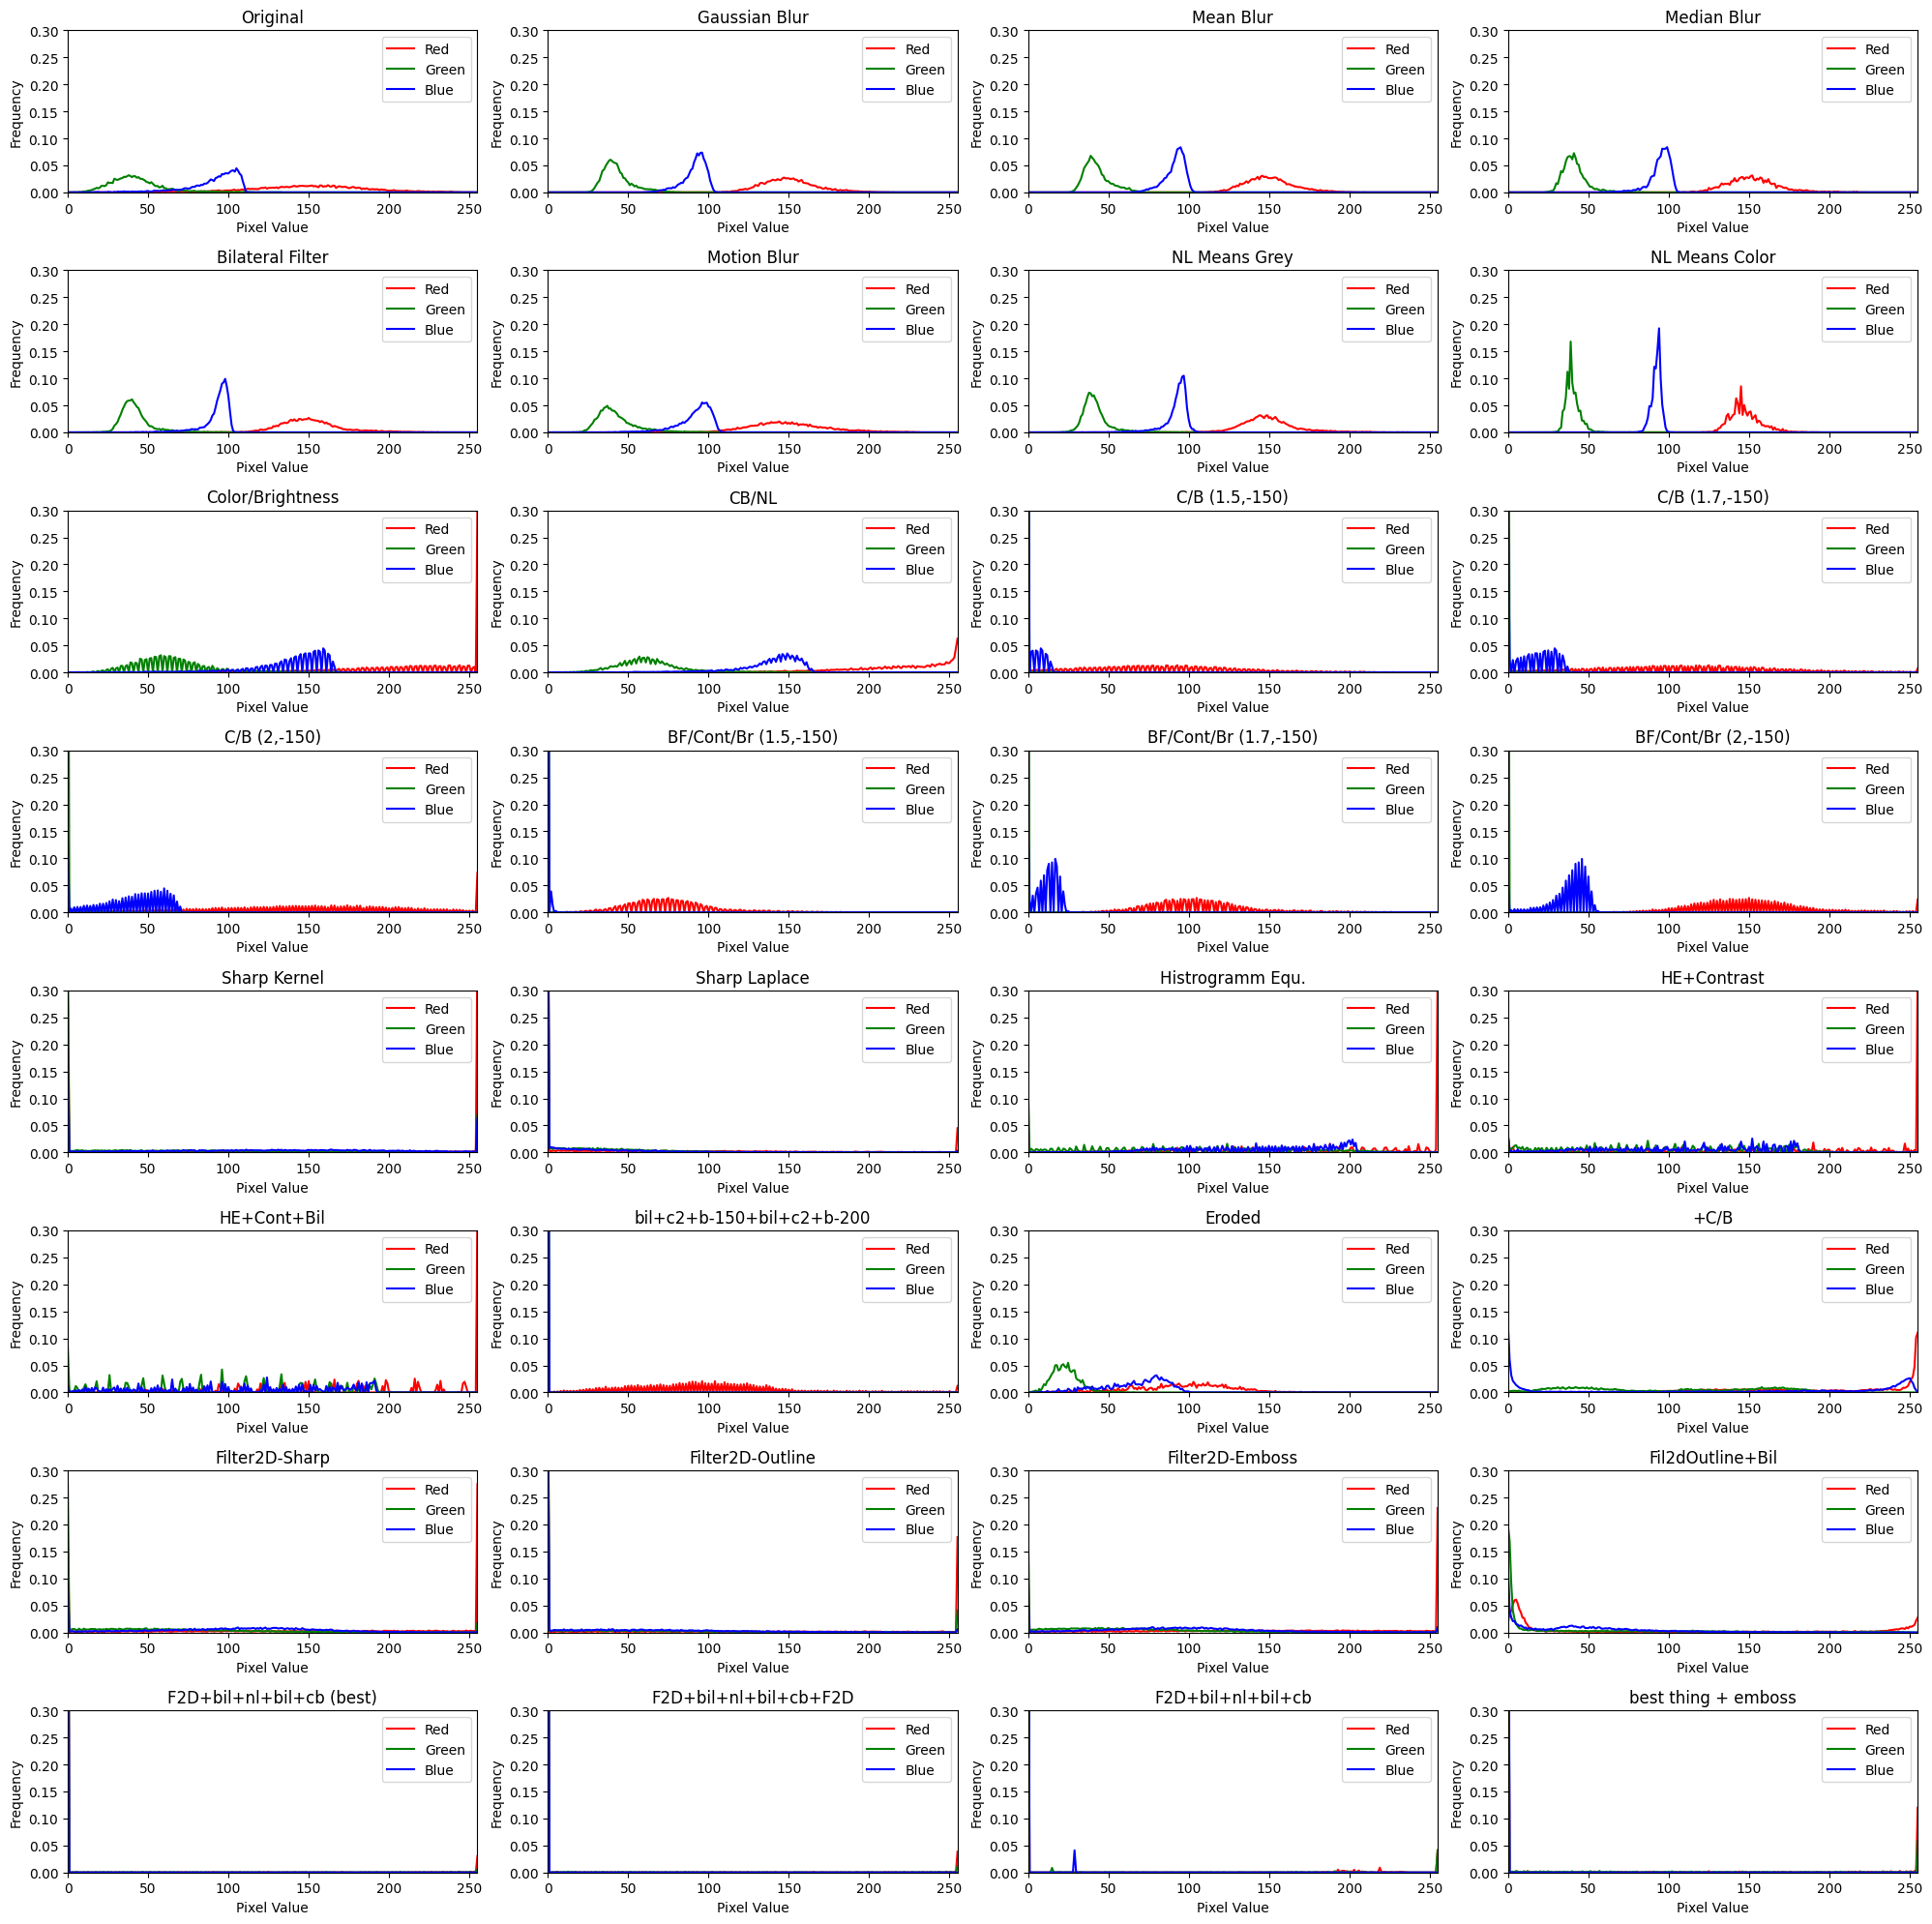

In [ ]:
##### spektrogramme anzeigen
def show_images(images, titles):
    plt.figure(figsize=(20, 20))
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(8, 4, i)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.savefig("denoise_comaprison.png")
    plt.show()

# color distribution to show differences in intesities etc
def show_hist(images, titles):
    plt.figure(figsize=(20, 20))
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(8, 4, i)
        plt.title(title)
        #plt.axis('off')
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        hist_r = cv2.calcHist([image_rgb], [0], None, [256], [0, 256]) / (image_size/3)
        hist_g = cv2.calcHist([image_rgb], [1], None, [256], [0, 256]) / (image_size/3)
        hist_b = cv2.calcHist([image_rgb], [2], None, [256], [0, 256]) / (image_size/3)

        plt.plot(hist_r, color='red', label='Red')
        plt.plot(hist_g, color='green', label='Green')
        plt.plot(hist_b, color='blue', label='Blue')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.xlim([0, 255])
        plt.ylim([0, 0.3])
    plt.tight_layout()
    plt.savefig("denoise_comaprison_hist.png")
    plt.show()

# Laden eines Beispielbildes
image = dfs['df_numerical']['data'][0]
image_size = image.size
with open("./data/meta.json","r") as file:  # get metadata for images from file generated from import nb
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c']) # hwc
image= image.reshape(image_shape)
image = cv2.cvtColor(image,cv2.COLOR_BGRA2BGR)

# Gaußscher Weichzeichner
gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)

# Mittelwertfilter
mean_blur = cv2.blur(image, (5, 5))

# Medianfilter
median_blur = cv2.medianBlur(image, 5)

# Bilateralfilter
bilateral_blur = cv2.bilateralFilter(image, 9, 75, 75)

# Bewegungsunschärfe
kernel_motion_blur = np.zeros((5, 5))
kernel_motion_blur[:, int((5-1)/2)] = 1
kernel_motion_blur /= 5
motion_blur = cv2.filter2D(image, -1, kernel_motion_blur)

# predcit based on autoencoder
#autoencoder = keras.saving.load_model('../autoencoder_files/autoencoder_cnn_denoise_v7.keras')
#imagelist = np.asarray([image]).astype('float32')/255.
#autoencoder_img = (autoencoder.predict(imagelist)[0]*255.).astype('uint8')

# nl means denosing gray
fast_nl_grey = cv2.fastNlMeansDenoising(image, None, h=15, templateWindowSize=7, searchWindowSize=21)

# nl means denosing color
fast_nl_color = cv2.fastNlMeansDenoisingColored(image, None, 15,15, templateWindowSize=7, searchWindowSize=21)

# contrast/birghness
brightness = 1 
contrast = 1.5
c_b = cv2.addWeighted(image, contrast, np.zeros(image.shape, image.dtype), 0, brightness)


# cb + nlmeans
brightness = 0 
contrast = 1.5
cb_nl = cv2.fastNlMeansDenoising(cv2.addWeighted(image, contrast, np.zeros(image.shape, image.dtype), 0, brightness), None, h=15, templateWindowSize=7, searchWindowSize=21)


# + cont
cont1 = cv2.addWeighted(image, 1.5, np.zeros(image.shape, image.dtype), 0, -150)

cont2 = cv2.addWeighted(image, 1.7, np.zeros(image.shape, image.dtype), 0, -150)

cont3 = cv2.addWeighted(image, 2, np.zeros(image.shape, image.dtype), 0, -150)

# bil + cont
img = cv2.bilateralFilter(image, 9, 75, 75)
bil_cont1 = cv2.addWeighted(img, 1.5, np.zeros(img.shape, img.dtype), 0, -150)

img = cv2.bilateralFilter(image, 9, 75, 75)
bil_cont2 = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)

img = cv2.bilateralFilter(image, 9, 75, 75)
bil_cont3 = cv2.addWeighted(img, 2, np.zeros(img.shape, img.dtype), 0, -150)

# bil+c2+b-150+bil+c2+b-200
img = cv2.bilateralFilter(image, 9, 75, 75)
img = cv2.addWeighted(img, 2, np.zeros(img.shape, img.dtype), 0, -150)
img = cv2.bilateralFilter(img, 9, 75, 75)
bl_cb_bil_cb1 = cv2.addWeighted(img, 2, np.zeros(img.shape, img.dtype), 0, -200)

#sharpen kernel
kernel = np.array([[-1, -1, -1],
                       [-1, 9, -1],
                       [-1, -1, -1]])
sharp_img = cv2.filter2D(image, -1, kernel)

#sharpen laplace
sharp_lapla = cv2.Laplacian(image, cv2.CV_8U) 

# equ hist
img = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
img[:,:,0] = cv2.equalizeHist(img[:,:,0])
equ_hist1 = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)

# equ hist + contrast
img = cv2.addWeighted(image, 1.7, np.zeros(image.shape, image.dtype), 0, -150)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
img[:,:,0] = cv2.equalizeHist(img[:,:,0])
equ_hist2 = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)

# equ hist + contrast + bilateral
img = cv2.bilateralFilter(image, 9, 75, 75)
img = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
img[:,:,0] = cv2.equalizeHist(img[:,:,0])
equ_hist3 = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)

# erode
kernel = np.array([[1, 9, 1],
                   [1, 9, 1],
                   [1, 9, 1]])
eroded1 = cv2.erode(image, kernel)

# c/b + equ hsit + bil
img = cv2.addWeighted(img, 2, np.zeros(img.shape, img.dtype), 0, -100)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
img[:,:,0] = cv2.equalizeHist(img[:,:,0])
img = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)
eroded2 = cv2.bilateralFilter(img, 9, 75, 75)

# filter 2d sharp
kernel = np.array([[0, -1, 0],
                  [-1, 5, -1],
                  [0, -1, 0]])
filter2d_1 = cv2.filter2D(image,-1,kernel)

# filter 2d outline
kernel = np.array([
  [-1, -1, -1],
  [-1, 8, -1],
  [-1, -1, -1]
])
filter2d_2 = cv2.filter2D(image,-1,kernel)

# filter 2d emboss
kernel = np.array([
  [-2, -1, 0],
  [-1, 1, 1],
  [0, 1, 2]
])
filter2d_3 = cv2.filter2D(image,-1,kernel)

#filter2d outline + bil
kernel = np.array([
  [-1, -1, -1],
  [-1, 8, -1],
  [-1, -1, -1]
])
img = cv2.filter2D(image,-1,kernel)
fil_bil1 = cv2.bilateralFilter(img, 9, 75, 75)

#filter2d (-1/7)+ bil + nl + bil + c1.7/b-150  (best thing yet)
kernel = np.array([
  [-1, -1, -1],
  [-1, 7, -1],
  [-1, -1, -1]
])
#img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
img = cv2.filter2D(image,-1,kernel)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.fastNlMeansDenoising(img, None, h=15, templateWindowSize=7, searchWindowSize=21)
img = cv2.bilateralFilter(img, 9, 75, 75)
fil_nl1 = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)

#filter2d (-1/7)+ bil + nl + c1.7/b-150 (okay)
kernel = np.array([
  [-1, -1, -1],
  [-1, 7, -1],
  [-1, -1, -1]
])
img = cv2.filter2D(image,-1,kernel)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.fastNlMeansDenoising(img, None, h=15, templateWindowSize=7, searchWindowSize=21)
fil_nl2 = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)

#filter2d (outline)+ bil + nl + c1.7/b-150 + f2d (sobel)
kernel = np.array([
  [-1, -1, -1],
  [-1, 7, -1],
  [-1, -1, -1]
])
img = cv2.filter2D(image,-1,kernel)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.fastNlMeansDenoising(img, None, h=15, templateWindowSize=7, searchWindowSize=21)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)
kernel = np.array([
  [-1, 0, 1],
  [-2, 0, 2],
  [-1, 0, 1]
])
img = cv2.filter2D(img,-1,kernel)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
img[:,:,0] = cv2.equalizeHist(img[:,:,0])
fil_nl3 = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)

# best thing + emboss
kernel = np.array([
  [-1, -1, -1],
  [-1, 7, -1],
  [-1, -1, -1]
])
img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
img = cv2.filter2D(img,-1,kernel)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.fastNlMeansDenoising(img, None, h=15, templateWindowSize=7, searchWindowSize=21)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)
kernel = np.array([
  [-2, -1, 0],
  [-1, 1, 1],
  [0, 1, 2]
])
fil_nl4 = cv2.filter2D(img,-1,kernel)

list = ([image, gaussian_blur, mean_blur, median_blur, bilateral_blur, motion_blur,fast_nl_grey,fast_nl_color,
         c_b,cb_nl,cont1,cont2,cont3,bil_cont1,bil_cont2,bil_cont3,sharp_img,sharp_lapla,equ_hist1,equ_hist2,
         equ_hist3,bl_cb_bil_cb1,eroded1, eroded2,filter2d_1,filter2d_2,filter2d_3,fil_bil1,fil_nl1,fil_nl2,fil_nl3,
         fil_nl4
        ],
        ['Original', 'Gaussian Blur', 'Mean Blur', 'Median Blur', 'Bilateral Filter', 'Motion Blur','NL Means Grey',
         'NL Means Color','Color/Brightness','CB/NL','C/B (1.5,-150)','C/B (1.7,-150)','C/B (2,-150)',
         'BF/Cont/Br (1.5,-150)', 'BF/Cont/Br (1.7,-150)', 'BF/Cont/Br (2,-150)', 'Sharp Kernel', 'Sharp Laplace',
         'Histrogramm Equ.', 'HE+Contrast', 'HE+Cont+Bil', "bil+c2+b-150+bil+c2+b-200", "Eroded", "+C/B", 'Filter2D-Sharp',
         "Filter2D-Outline", "Filter2D-Emboss", "Fil2dOutline+Bil", "F2D+bil+nl+bil+cb (best)", "F2D+bil+nl+bil+cb+F2D",
         "F2D+bil+nl+bil+cb", "best thing + emboss"])

# Anzeigen der Ergebnisse
show_images(*list)
show_hist(*list)

